In [46]:
import pandas as pd
import numpy as np
import os
import os.path

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as snsplt
os.environ['PROJ_LIB'] = '/anaconda3/pkgs/proj4/share/proj'
# from mpl_toolkits.basemap import Basemap

import matplotlib.cm
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
import seaborn as sns

from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score

from sklearn.ensemble import BaggingClassifier
from sklearn import tree

from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.linear_model import LogisticRegressionCV

import warnings
warnings.filterwarnings('ignore')

In [47]:
os.getcwd()

'/Users/colleendriscoll/Dropbox/Classes/CS 109A/CS 109A Final project/code'

In [48]:
# comb_data=pd.read_csv("/Users/poojatyagi/Dropbox (MIT)/CS109_project_data/Usefuldata/combined_data.csv")
local_data_folder = "/Users/colleendriscoll/Dropbox/Classes/CS 109A/CS 109A Final project/data/"
comb_data = pd.read_csv(local_data_folder +"combined_data.csv")
comb_data.head()

year dist_id  dem_vote_share  congress    icpsr  nominate_dim1  \
0  2006    AK_1        0.414254     109.0  14066.0          0.279   
1  2008    AK_1        0.472837     110.0  14066.0          0.279   
2  2010    AK_1        0.306755     111.0  14066.0          0.279   
3  2012    AK_1        0.309172     112.0  14066.0          0.279   
4  2014    AK_1        0.445620     113.0  14066.0          0.279   

   nominate_dim2  nokken_poole_dim1  nokken_poole_dim2   age     ...      \
0          0.014              0.367             -0.047  73.0     ...       
1          0.014              0.291              0.269  75.0     ...       
2          0.014              0.242              0.642  77.0     ...       
3          0.014              0.338             -0.052  79.0     ...       
4          0.014              0.265              0.116  81.0     ...       

      house    senate  median_HH_income  median_age  mortgage_cost  \
0  0.464368  0.484848           25793.0        33.5         1015.0   
1  0.535632  0.500000           30271.0        33.0         1166.0   
2  0.590805  0.581633           28202.0        33.8         1167.0   
3  0.443678  0.520408           29932.0        33.8         1239.0   
4  0.462069  0.540816           31557.0        33.3         1258.0   

   unemp_rate  bachelor_deg_perc  black_perc  HS_diploma_perc  white_perc  
0         9.4           0.107839    0.032051         0.177972    0.686767  
1         7.7           0.108886    0.036257         0.164006    0.691129  
2         9.6           0.116734    0.034610         0.159744    0.674308  
3         7.8           0.108769    0.035829         0.178108    0.665188  
4         7.6           0.116235    0.033649         0.179152    0.656391  

[5 rows x 23 columns]

In [49]:
(comb_data).columns

Index(['year', 'dist_id', 'dem_vote_share', 'congress', 'icpsr',
       'nominate_dim1', 'nominate_dim2', 'nokken_poole_dim1',
       'nokken_poole_dim2', 'age', 'dem_incumbent', 'dem_prior_vote_share',
       'president', 'house', 'senate', 'median_HH_income', 'median_age',
       'mortgage_cost', 'unemp_rate', 'bachelor_deg_perc', 'black_perc',
       'HS_diploma_perc', 'white_perc'],
      dtype='object')

In [50]:
comb_data.shape

(3032, 23)

In [51]:
#Test Data = Data for year 2018
testdata=comb_data[comb_data.year==2018]

#Train Data = Data for years other than 2018
traindata=comb_data[comb_data.year!=2018]

testdata.shape, traindata.shape

((435, 23), (2597, 23))

In [52]:
comb_data.columns

Index(['year', 'dist_id', 'dem_vote_share', 'congress', 'icpsr',
       'nominate_dim1', 'nominate_dim2', 'nokken_poole_dim1',
       'nokken_poole_dim2', 'age', 'dem_incumbent', 'dem_prior_vote_share',
       'president', 'house', 'senate', 'median_HH_income', 'median_age',
       'mortgage_cost', 'unemp_rate', 'bachelor_deg_perc', 'black_perc',
       'HS_diploma_perc', 'white_perc'],
      dtype='object')

In [53]:
#List of predictors we want to use
predictors=['nominate_dim1', 'nominate_dim2', 'nokken_poole_dim1',
       'nokken_poole_dim2', 'age', 'dem_incumbent', 'president', 'house',
       'senate', 'median_HH_income', 'median_age', 'mortgage_cost',
       'unemp_rate', 'bachelor_deg_perc', 'black_perc', 'HS_diploma_perc',
       'white_perc']

#Columns to drop in Xtest and Xtrain
columns_to_drop=set(comb_data.columns) - set(predictors)

In [54]:
#Response Variable for test and train data sets = Democrat Vote Share
ytest=testdata.dem_vote_share
ytrain=traindata.dem_vote_share


#Xdata for test and train data
xtest=testdata.drop(columns_to_drop, axis=1, inplace = False)
xtrain=traindata.drop(columns_to_drop, axis=1, inplace = False)

In [55]:
ytrain.shape, xtrain.shape

((2597,), (2597, 17))

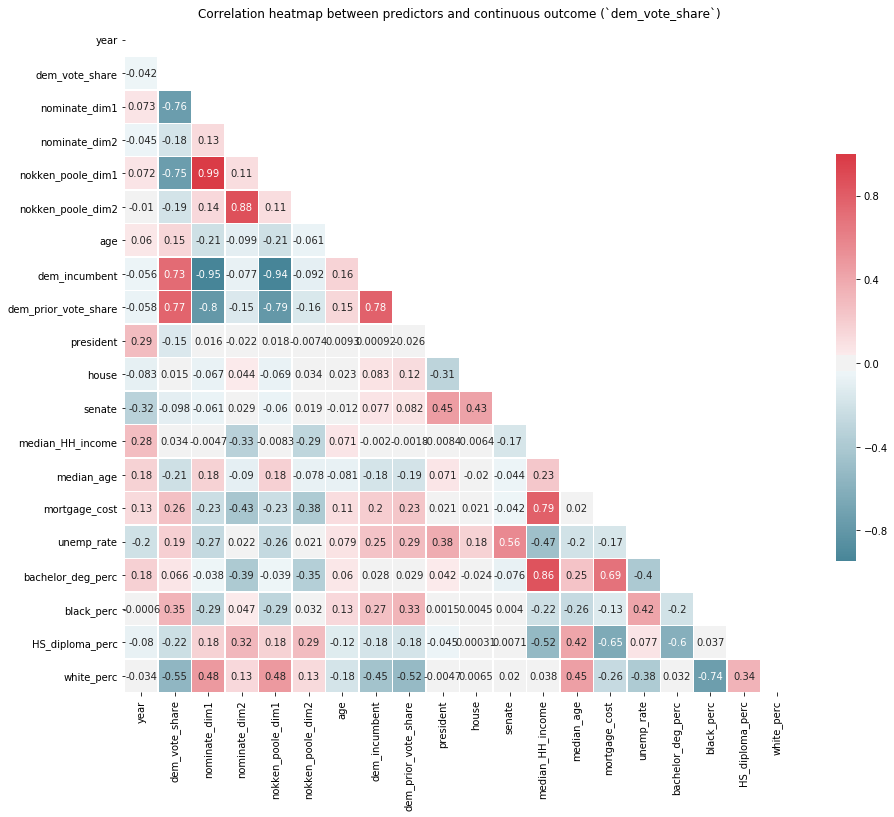

In [56]:
heatmap_data = comb_data.drop(['congress', 'icpsr'], axis = 1, inplace = False)
mask = np.zeros_like(heatmap_data.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ax = plt.axes()
sns.heatmap(heatmap_data.corr(), mask=mask, cmap=cmap, #vmax=.3,
            center=0,annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax = ax)
ax.set_title('Correlation heatmap between predictors and continuous outcome (`dem_vote_share`)')
plt.show();

In [57]:
#Convert the dem_vote_share to binary output
def get_binary(response):
    binary=[]
    for i in range(len(response)):
        if response.iloc[i] <0.5:
            out=0 
        else:
            out = 1 
        binary.append(out)
    binary=pd.DataFrame(binary)
    return binary

In [58]:
#binary response data
binarytest=get_binary(ytest)
binarytrain=get_binary(ytrain)

In [59]:
# Fit logistic regression on training data 

from sklearn.linear_model import LogisticRegression

logreg1 = LogisticRegression( C=100000)
logreg1.fit(xtrain, binarytrain)

# Make Prediction and check the accuracy
y_test_probs=(logreg1.predict_proba(xtest))
y_train_probs=(logreg1.predict_proba(xtrain))

logreg1_testscore=logreg1.score(xtest, binarytest)
logreg1_trainscore=logreg1.score(xtrain, binarytrain)

print('Accuracy of logistic regression classifier on train set: {0:.2f}%'.format(logreg1_trainscore))
print('Accuracy of logistic regression classifier on test set: {0:.2f}%'.format(logreg1_testscore))

Accuracy of logistic regression classifier on train set: 0.91%
Accuracy of logistic regression classifier on test set: 0.90%


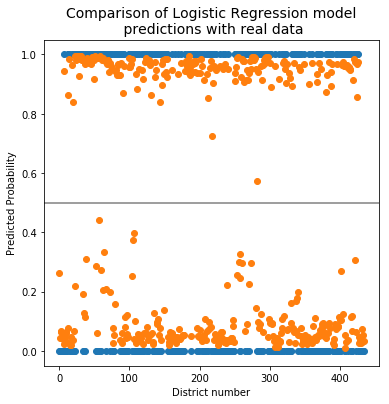

In [60]:
fig1,ax1=plt.subplots(figsize=[6,6])
plt.plot(binarytest,'o',label = "True results")
plt.plot(y_test_probs[:,1],'o', label ="Prediction")
plt.xlabel("District number")
plt.ylabel("Predicted Probability")
plt.axhline(0.5, color="gray")
plt.title("Comparison of Logistic Regression model\n predictions with real data", fontsize=14);

In [61]:
scoretrain=[]
scoretest=[]
for i in range(1,25,2):
    RF1= RandomForestClassifier(max_depth=i, n_estimators=40)
    RF1.fit(xtrain, binarytrain)
    scoretrain.append(accuracy_score(binarytrain,  RF1.predict(xtrain)))
    scoretest.append(accuracy_score(binarytest,  RF1.predict(xtest)))

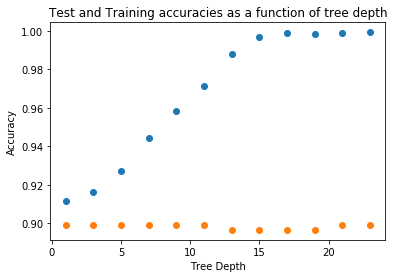

In [62]:
plt.plot(range(1,25,2), scoretrain,'o')
plt.plot(range(1,25,2), scoretest,'o')
plt.title("Test and Training accuracies as a function of tree depth")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy");

In [63]:
#The best # of trees = 15
RF2= RandomForestClassifier(max_depth=15, n_estimators=40)
RF2.fit(xtrain, binarytrain)

y_predRF_train = RF2.predict(xtrain)
y_predRF_test = RF2.predict(xtest)

#Perfromance Evaluation
trainRF_score = accuracy_score(binarytrain, y_predRF_train)
testRF_score = accuracy_score(binarytest, y_predRF_test)

print("Random Forest Accuracy, Training Set : {0:.2f}%".format(trainRF_score*100))
print("Random Forest Accuracy, Testing Set: {0:.2f}%".format(testRF_score*100))

Random Forest Accuracy, Training Set : 99.73%
Random Forest Accuracy, Testing Set: 89.66%


In [64]:
#Baggine Classifier
bag1 = BaggingClassifier(tree.DecisionTreeClassifier(random_state=1))
bag1.fit(xtrain, binarytrain)
bag1_trainscore=bag1.score(xtrain,binarytrain)
bag1_testscore=bag1.score(xtest,binarytest)
print("Bagging Accuracy, Training Set : {0:.2f}%".format(bag1_trainscore))
print("Bagging Accuracy, Testing Set: {0:.2f}%".format(bag1_testscore))

Bagging Accuracy, Training Set : 0.99%
Bagging Accuracy, Testing Set: 0.90%


In [65]:
#Scale Data to have mean = 1 and std =1
#Ridge regression on Scaled Data
xtrain_scaled=pd.DataFrame(preprocessing.scale(xtrain))
xtest_scaled=pd.DataFrame(preprocessing.scale(xtest))
ridge1= linear_model.Ridge(alpha=0.5)
ridge1.fit(xtrain,ytrain)

ridge1_testpred=pd.Series(ridge1.predict(xtest))
binarytest_ridgepred=get_binary(ridge1_testpred)

ridge1_trainpred=pd.Series(ridge1.predict(xtrain))
binarytrain_ridgepred=get_binary(ridge1_trainpred)


ridge1_testscore=accuracy_score(binarytest_ridgepred,binarytest)
ridge1_trainscore=accuracy_score(binarytrain_ridgepred,binarytrain)

print("Ridge Accuracy, Training Set : {0:.2f}%".format(ridge1_trainscore))
print("Ridge Accuracy, Testing Set: {0:.2f}%".format(ridge1_testscore))

Ridge Accuracy, Training Set : 0.91%
Ridge Accuracy, Testing Set: 0.90%


In [66]:
#Logistic Regression with cross-validation and L1 regularization (Lasso)

logregcv1 = LogisticRegressionCV(cv=5, penalty='l1', solver='liblinear').fit(xtrain, binarytrain)
logregcvlasso_testscore= logregcv1.score(xtest, binarytest) 
logregcvlasso_trainscore= logregcv1.score(xtrain, binarytrain) 

print("Lasso with CV Accuracy, Training Set : {0:.2f}%".format(logregcvlasso_trainscore))
print("Lasso with CV Accuracy, Testing Set: {0:.2f}%".format(logregcvlasso_testscore))

Lasso with CV Accuracy, Training Set : 0.91%
Lasso with CV Accuracy, Testing Set: 0.90%


In [67]:
#Logistic Regression with cross-validation and L2 regularization (Ridge)

logregcv2 = LogisticRegressionCV(cv=5, penalty='l2').fit(xtrain, binarytrain)

logregcvridge_testscore= logregcv2.score(xtest, binarytest) 
logregcvridge_trainscore= logregcv2.score(xtrain, binarytrain) 

print("Ridge with CV Accuracy, Training Set : {0:.2f}%".format(logregcvridge_trainscore))
print("Ridge with CV Accuracy, Testing Set: {0:.2f}%".format(logregcvridge_testscore))

Ridge with CV Accuracy, Training Set : 0.91%
Ridge with CV Accuracy, Testing Set: 0.89%


In [68]:
accuracies_table = {'classifier':['Logistic Regression', 'Logistic Regression with CV (Lasso)',
'Logistic Regression with CV (Ridge)','Linear Regression (Ridge)','Bagging','Random Forest'],                    
'training accuracy':[logreg1_trainscore, logregcvlasso_testscore, logregcvridge_trainscore,ridge1_trainscore,                    
bag1_trainscore, trainRF_score],
'test accuracy':[logreg1_testscore, logregcvlasso_testscore, logregcvridge_testscore,ridge1_testscore,
bag1_testscore, testRF_score]}
accuracies_table_df = pd.DataFrame(accuracies_table)
print("Summary of Models used:")
accuracies_table_df

Summary of Models used:


classifier  training accuracy  test accuracy
0                  Logistic Regression           0.908356       0.896552
1  Logistic Regression with CV (Lasso)           0.896552       0.896552
2  Logistic Regression with CV (Ridge)           0.907971       0.894253
3            Linear Regression (Ridge)           0.909896       0.901149
4                              Bagging           0.986908       0.898851
5                        Random Forest           0.997305       0.896552

In [ ]:
def add_power_terms(df, continuous_colnames, degree):
    if degree > 2 & degree % 1 == 0:
        for i in range(2, degree+1):
            for col in continuous_colnames:
                new_colname = col+"^"+str(i)
                df[new_colname] = df[col]**i
    else:
        if degree == 1:
            return(df)
        else:
            print("Invalid degree term")
    return(df)

def add_interaction_terms(df, continuous_colnames):
    binary_colnames = df.columns.difference(continuous_colnames)
    ## removing power terms
    binary_colnames = [x for x in binary_colnames if "^" not in x]
    
    for continuous_colname in continuous_colnames:
        for binary_colname in binary_colnames:
            interaction_colname = continuous_colname + "*" + binary_colname
            df[interaction_colname] = df[continuous_colname]*df[binary_colname]
    return(df)
